In [189]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, ttest_ind
from sklearn.manifold import TSNE

In [190]:
# Read the raw database that was created in the bleaching_statistics.py script
db = pd.read_json('raw_window_10_params_11.json')
db.head()

,lat,lng,month,raw_chlor_a_aqua,raw_chlor_a_seawifs,raw_chlor_a_terra,raw_cloud_transmission,raw_salinity,raw_sst,raw_sst_avhrr,raw_sst_whoi,raw_velocity_u,raw_velocity_v,raw_wind_avhrr,severity,year
0,-21.22,55.22,4,"[0.248802691698074, 0.20917397737503002, 0.132...","[0.06279426068067501, 0.107715182006359, 0.083...","[0.187744826078414, 0.13887885212898202, 0.093...","[0.48031522000000004, 0.31102379, 0.47637821, ...","[15.204, 15.203000000000001, 15.189, 15.179, 1...","[27.25, 27.28, 27.21, 27.11, 27.11, 27.02, 26....","[4.82, 4.53, 8.69, 22.7, 23.31, 19.47, -0.01, ...","[27.2310791015625, 27.25569725036621, 27.30441...","[-0.088, -0.083, -0.27, -0.117, 0.017, -0.15, ...","[0.09, -0.053, -0.10400000000000001, -0.061, -...","[9.0, 10.0, 11.0, 9.0, 10.0, 9.0, 10.0, 4.0, 9...",0,2008
1,-21.05,55.23,7,[],[],[],[],[],[],[],[],[],[],[],0,2008
2,-21.16,55.28,2,[],[],[],[],[],[],[],[],[],[],[],0,2008
3,43.00,5.00,8,[],"[0.299542069435119, 0.29057654738426203, 0.283...",[],"[0.39763801000000004, 0.49606326000000006, 0.4...","[18.016000000000002, 18.067, 18.108, 18.097, 1...","[21.62, 20.990000000000002, 20.79, 20.98, 21.3...","[20.68, 18.900000000000002, 19.990000000000002...","[21.790637969970703, 21.631603240966797, 21.59...","[0.059000000000000004, -0.17300000000000001, -...","[-0.246, -0.548, -0.39, 0.016, -0.012, -0.169,...","[15.0, 11.0, 11.0, 2.0, 4.0, 6.0, 1.0, 5.0, 3....",-1,1999
4,10.12,99.81,7,"[0.501900017261505, 0.5892923474311821, 0.9793...",[0.8815642595291131],"[1.379987835884094, 1.347643375396728, 2.49852...","[0.18897648, 0.11417329000000001, 0.2362206000...","[10.487, 10.482000000000001, 10.485, 10.482000...","[29.66, 30.21, 29.8, 29.27, 29.23, 29.15000000...","[-2.62, 24.34, -1.73, 1.45, 24.23, 26.83000000...",[],"[0.073, 0.093, 0.121, 0.016, 0.033, 0.061, 0.0...","[0.083, 0.08600000000000001, 0.134, 0.07, 0.06...","[7.0, 6.0, 5.0, 6.0, 6.0, 4.0, 4.0, 3.0, 6.0, ...",0,2009


Define the named variables. These are the human interpretable base forms of the variables of interest rather than the product names. For example, chlor_a rather than `chlor_a_seawifs`.

Each parameter also has min and max parameters for filtering. These values are set by hand based on physically plausible parameters. This is done because the sensed data has anomalous outliers (e.g. wave velocity > 1000m/s).

In [191]:
variables = {
    "sst": {
        "min": 5,
        "max": 50
    },
    "chlor_a": {
        "min": 0,
        "max": 1
    },
    "velocity": {
        "min": 0,
        "max": 50
    },
    "salinity": {
        "min": 0,
        "max": 20
    },
    "wind_avhrr": {
        "min": 0,
        "max": 50
    },
    "cloud_transmission": {
        "min": -127,
        "max": 127
    }
}

The raw velocity data is in a signed vector component format. Here, we are only interested in the magnitude of the velocity, so it is converted before the next steps, and the component columns are deleted

In [192]:
# Convert directional component velocity into a velocity magnitude
magnitude = lambda u, v: math.sqrt(u ** 2  + v ** 2)
velocity_mag = []
for vel_u, vel_v in zip(db['raw_velocity_u'], db['raw_velocity_u']):
    mag = [magnitude(u, v) for u, v in zip(vel_u, vel_v)]
    velocity_mag.append(mag)
db['raw_velocity'] = velocity_mag
db = db.drop(columns = ['raw_velocity_u', 'raw_velocity_v'])

The database contains raw data. Here, all columns containing `raw_data`, are processed according to the previously set max and min values to remove outliers that are likely artifacts.

In [193]:
# Filter the raw input data
for variable in db.columns:
    if 'raw_' in variable:
        product = str.split(variable, 'raw_')[1]
        filtered_values = []
        for entry in db[variable]:
            for category in variables:
                if category in product:
                    min = variables[category]['min']
                    max = variables[category]['max']

            filtered_entry = [value for value in entry if value < max and value > min]
            filtered_values.append(filtered_entry)
        db[product] = filtered_values

Different sources of information are combined. For example, there are three different sources of chlorophyll a concentration (MODIS-Aqua, MODIS-Terra, and SeaWIFS). The products are assigned a priority. Data from preferred sources is used when multiple sources of data are available

In [196]:
# Merge the multiple sources of chlorophyll a
# Prefer seawifs, then modis terra, then modis aqua
db['chlor_a'] = db['chlor_a_seawifs'].fillna(db['chlor_a_terra']).fillna(db['chlor_a_aqua'])

# Merge the multiple sources of temperature
# Prefer OISST, then sst WHOI model, then AVHRR (AVHRR is probably good, but can't measure through clouds
db['sst'] = db['sst'].fillna(db['sst_whoi']).fillna(db['sst_avhrr'])

Basic statistics are calculated. This is especially useful as it moves the data from a format of lists of various shapes, into consistent values

In [197]:
for variable in db.columns:
    if variable in variables:
        means, meds, mins, maxs, variances = [], [], [], [], []
        for entry in db[variable]:
            if len(entry) > 0:
                means.append(np.mean(entry))
                meds.append(np.median(entry))
                mins.append(np.min(entry))
                maxs.append(np.max(entry))
                variances.append(np.var(entry))
            else:
                means.append(np.NaN)
                meds.append(np.NaN)
                mins.append(np.NaN)
                maxs.append(np.NaN)
                variances.append(np.NaN)
        db['mean_' + variable] = means
        db['med_' + variable] = meds
        db['min_' + variable] = mins
        db['max_' + variable] = maxs
        db['variance_' + variable] = variances

Do a simple t-test comparison for each of the parameters to see if there is a significant difference in values between bleaching events, and non-bleaching observations.

Notes:
- I probably should find a way to present this data beter. Maybe a table?
- I have a lot of doubt in these _extremely significant_ values. Need to think about it more

In [200]:
stats = ['mean_', 'med_', 'min_', 'max_']
healthy = db[db['severity'] == 0]
bleaching = db[db['severity'] != 0]

for variable in variables:
    for stat in stats:
        pval = ttest_ind(healthy[stat + variable].dropna(), bleaching[stat + variable].dropna()).pvalue
        print(stat + variable, "healthy {0:.2f}, bleaching {1:.2f}, pval: {2:.6f}".format(healthy[stat + variable].dropna().mean(), bleaching[stat + variable].dropna().mean(), pval))

mean_sst healthy 27.86, bleaching 28.45, pval: 0.000000
med_sst healthy 27.88, bleaching 28.47, pval: 0.000000
min_sst healthy 27.14, bleaching 27.68, pval: 0.000000
max_sst healthy 28.50, bleaching 29.11, pval: 0.000000
mean_chlor_a healthy 0.34, bleaching 0.26, pval: 0.000000
med_chlor_a healthy 0.33, bleaching 0.25, pval: 0.000000
min_chlor_a healthy 0.20, bleaching 0.15, pval: 0.000000
max_chlor_a healthy 0.52, bleaching 0.41, pval: 0.000000
mean_velocity healthy 0.49, bleaching 0.51, pval: 0.151894
med_velocity healthy 0.17, bleaching 0.18, pval: 0.024164
min_velocity healthy 0.03, bleaching 0.03, pval: 0.989332
max_velocity healthy 5.25, bleaching 5.01, pval: 0.289057
mean_salinity healthy 15.06, bleaching 15.40, pval: 0.000000
med_salinity healthy 15.06, bleaching 15.40, pval: 0.000000
min_salinity healthy 14.90, bleaching 15.27, pval: 0.000000
max_salinity healthy 15.16, bleaching 15.50, pval: 0.000000
mean_wind_avhrr healthy 6.21, bleaching 5.82, pval: 0.000000
med_wind_avhrr 

# All of the figures!!

In [210]:
colors =['#343754', '#8D99AE', '#D65959', '#C93434', '#AC0808']
ordered_severity = [0, -1, 1, 2, 3]

### Basic comparison of values between bleaching events, and healthy observations

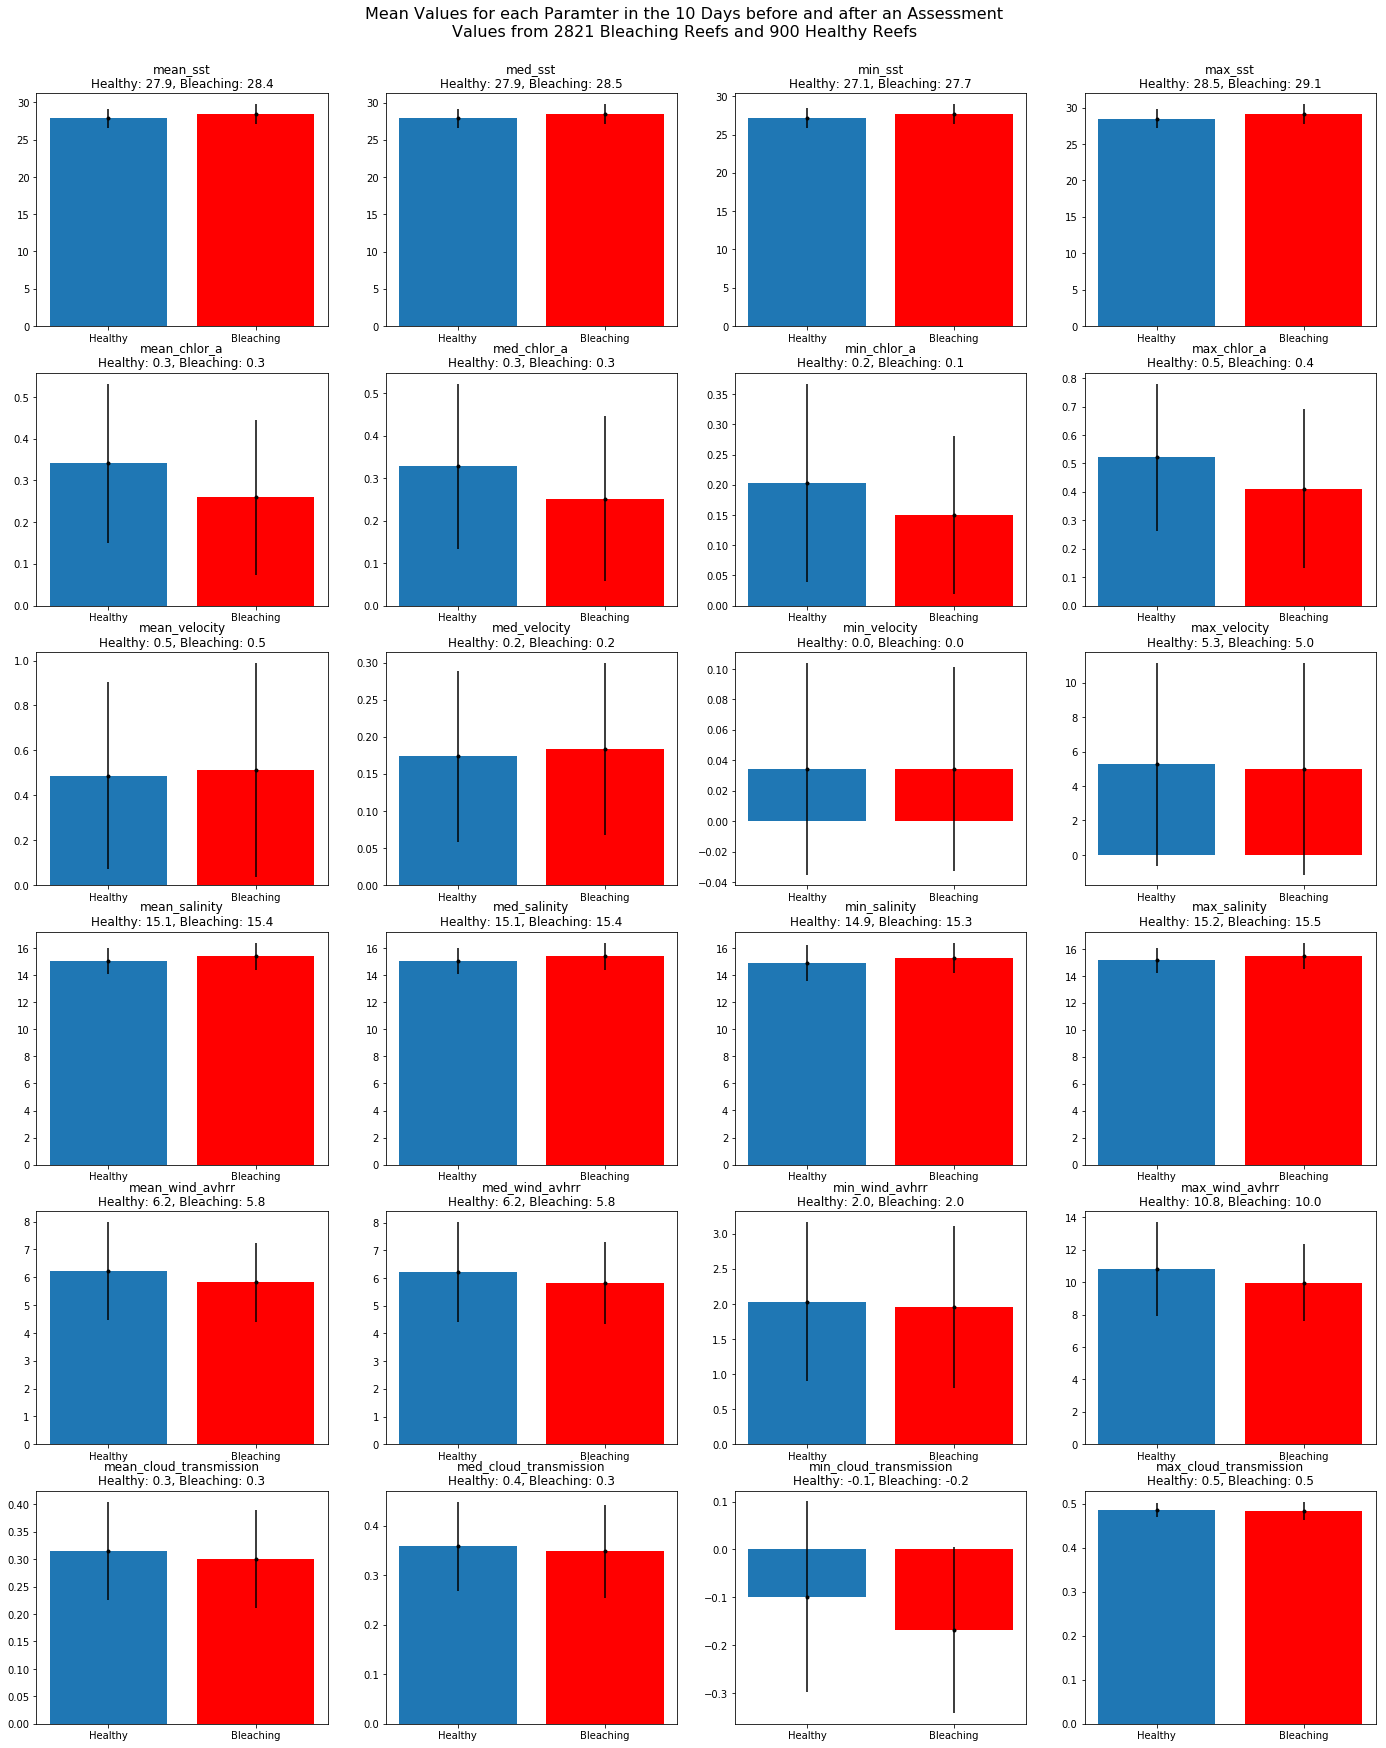

In [211]:
counter = 1
plt.figure(figsize=(24, 30))
for variable in variables:
    for stat in stats:
        mean_healthy = healthy[stat + variable].mean()
        var_healthy = math.sqrt(healthy[stat + variable].var())
        mean_bleaching = bleaching[stat + variable].mean()
        var_bleaching = math.sqrt(bleaching[stat + variable].var())
        plt.subplot(len(variables), len(stats), counter)
        plt.errorbar([0, 1], [mean_healthy, mean_bleaching], [var_healthy, var_bleaching], fmt='.', color='black')
        plt.bar(0, mean_healthy)
        plt.bar(1, mean_bleaching, color='r')
        plt.xticks([0, 1], ['Healthy', 'Bleaching'])
        #plt.legend(['Healthy', 'Bleaching'])
        title = str(stat + variable + "\nHealthy: {0:.1f}, Bleaching: {1:.1f}").format(mean_healthy, mean_bleaching)
        plt.title(title)
        counter += 1
plt.suptitle('Mean Values for each Paramter in the 10 Days before and after an Assessment\nValues from 2821 Bleaching Reefs and 900 Healthy Reefs', size=16, y=0.92)
#plt.savefig('figures/Comparison of Mean Values - Window 10.png', dpi=300, bbox_inches='tight')
plt.show()

### Plot of the distribution of values by bleaching and healthy

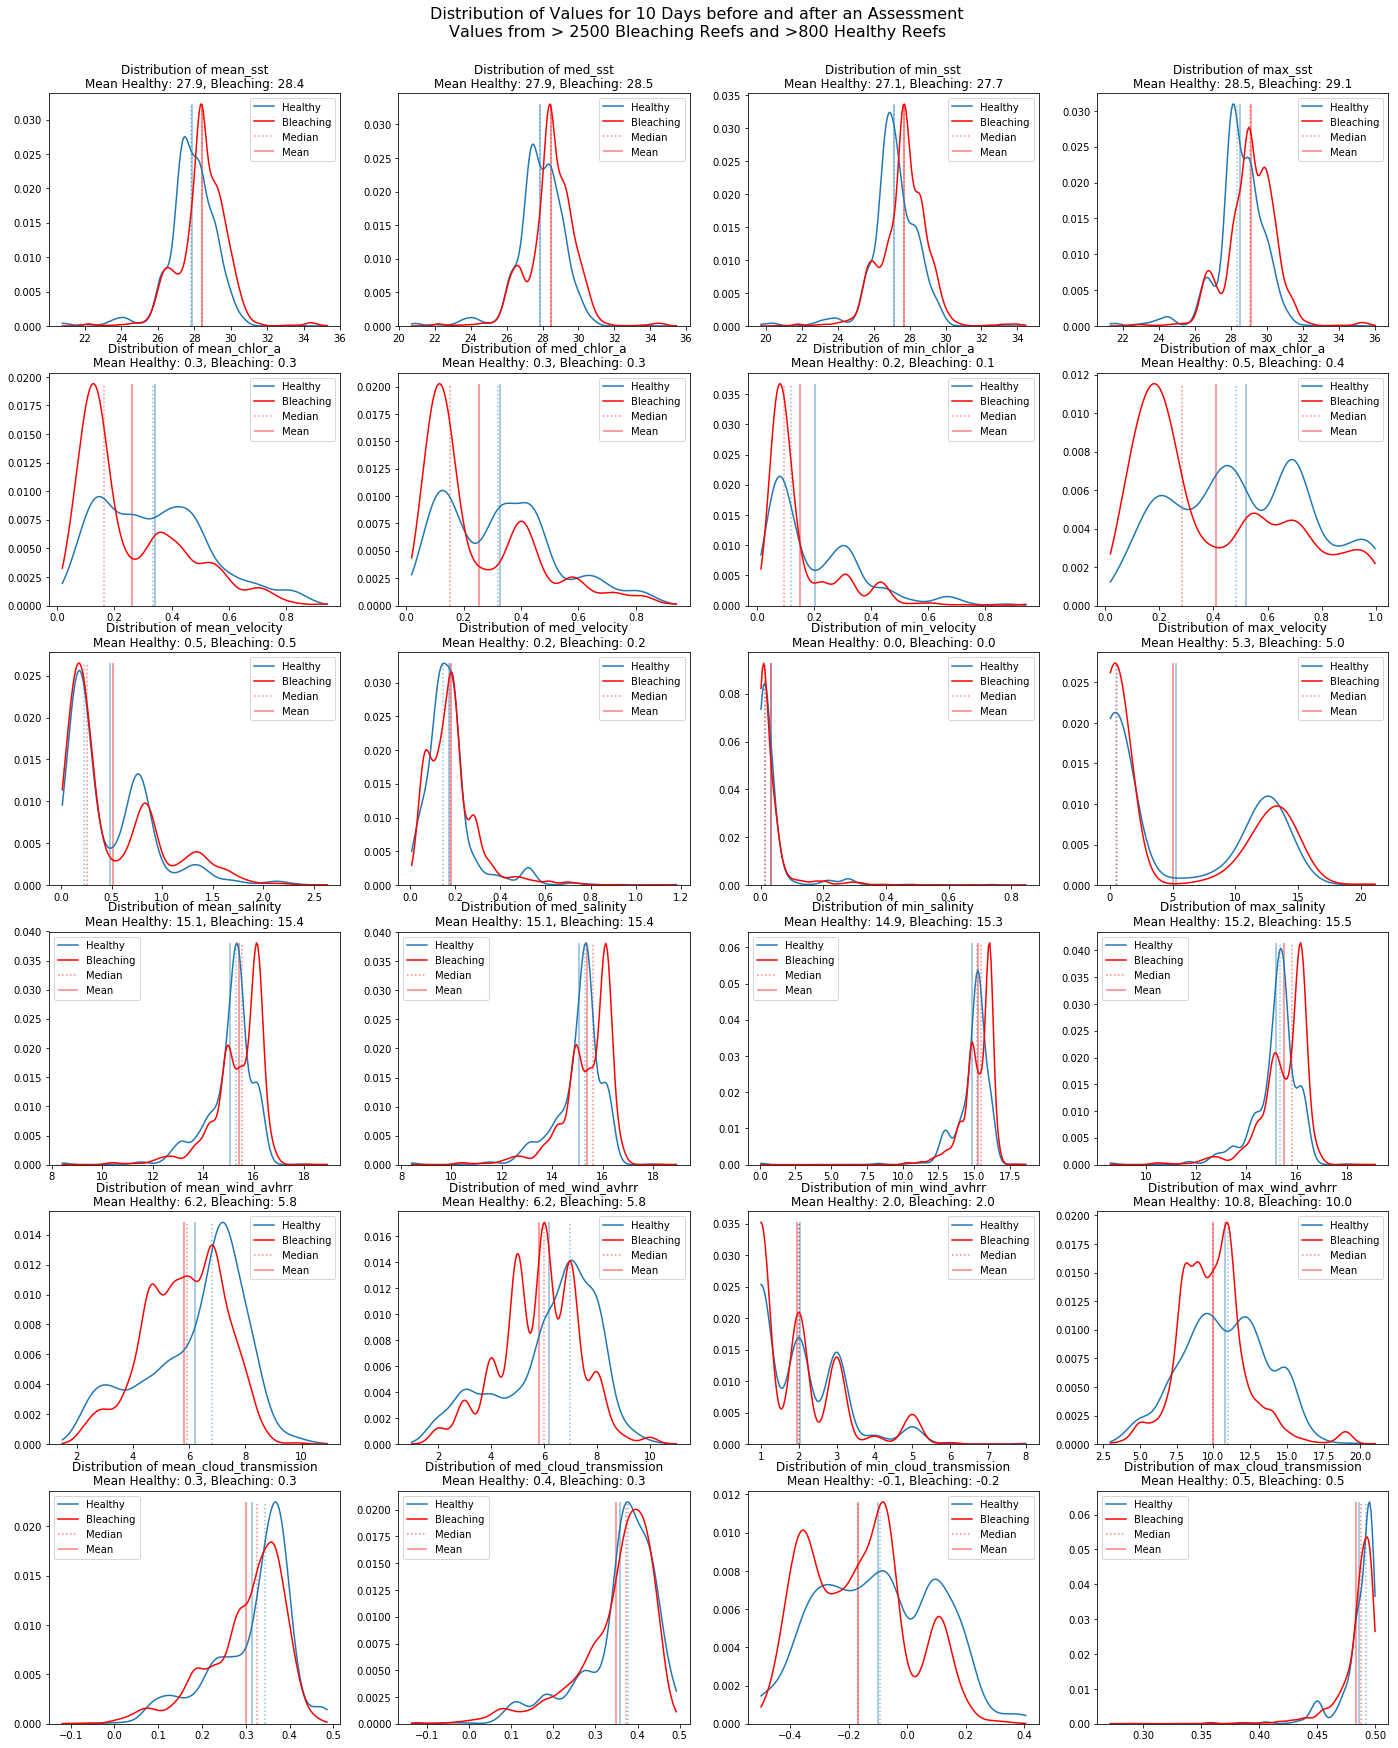

In [203]:
counter = 1
plt.figure(figsize=(24, 30))
for variable in variables:
    for stat in stats:
        val_healthy = healthy[stat + variable].dropna()
        val_bleaching = bleaching[stat + variable].dropna()
        min_val = np.min(pd.concat([val_bleaching, val_healthy]))
        max_val = np.max(pd.concat([val_bleaching, val_healthy]))
        xs = np.linspace(min_val, max_val, 200)

        density_healthy = gaussian_kde(val_healthy)
        normed_healthy = density_healthy(xs)/np.sum(density_healthy(xs))
        density_bleaching = gaussian_kde(val_bleaching)
        normed_bleaching = density_bleaching(xs)/np.sum(density_bleaching(xs))

        median_healthy = np.median(val_healthy)
        median_bleaching = np.median(val_bleaching)

        mean_healthy = np.mean(val_healthy)
        mean_bleaching = np.mean(val_bleaching)
        
        plt.subplot(len(variables), len(stats), counter)

        plt.plot(xs, normed_healthy, label='Healthy')
        plt.plot(xs, normed_bleaching, color='red', label='Bleaching')
        plt.vlines(median_healthy, 0, np.max([normed_healthy, normed_bleaching]), color='C0', alpha = 0.5, linestyle=':')
        plt.vlines(median_bleaching, 0, np.max([normed_healthy, normed_bleaching]), color='r', alpha = 0.5, linestyle=':', label='Median')

        plt.vlines(mean_healthy, 0, np.max([normed_healthy, normed_bleaching]), color='C0', alpha = 0.5)
        plt.vlines(mean_bleaching, 0, np.max([normed_healthy, normed_bleaching]), color='r', alpha = 0.5, label='Mean')

        plt.ylim(bottom=0)
        #plt.legend(['Healthy', 'Bleaching', 'Median', '_nolegend_', 'Mean'])
        plt.legend()
        title = str("Distribution of " + stat + variable + "\nMean Healthy: {0:.1f}, Bleaching: {1:.1f}").format(np.mean(val_healthy), np.mean(val_bleaching))
        plt.title(title)
        counter += 1
plt.suptitle('Distribution of Values for 10 Days before and after an Assessment\nValues from > 2500 Bleaching Reefs and >800 Healthy Reefs', size=16, y=0.92)
#plt.savefig('figures/Distributions of Values - Window 10.png', dpi=300, bbox_inches='tight')
plt.show()

### Plot of the mean values for each of the parameters and statistics, grouped by bleaching severity

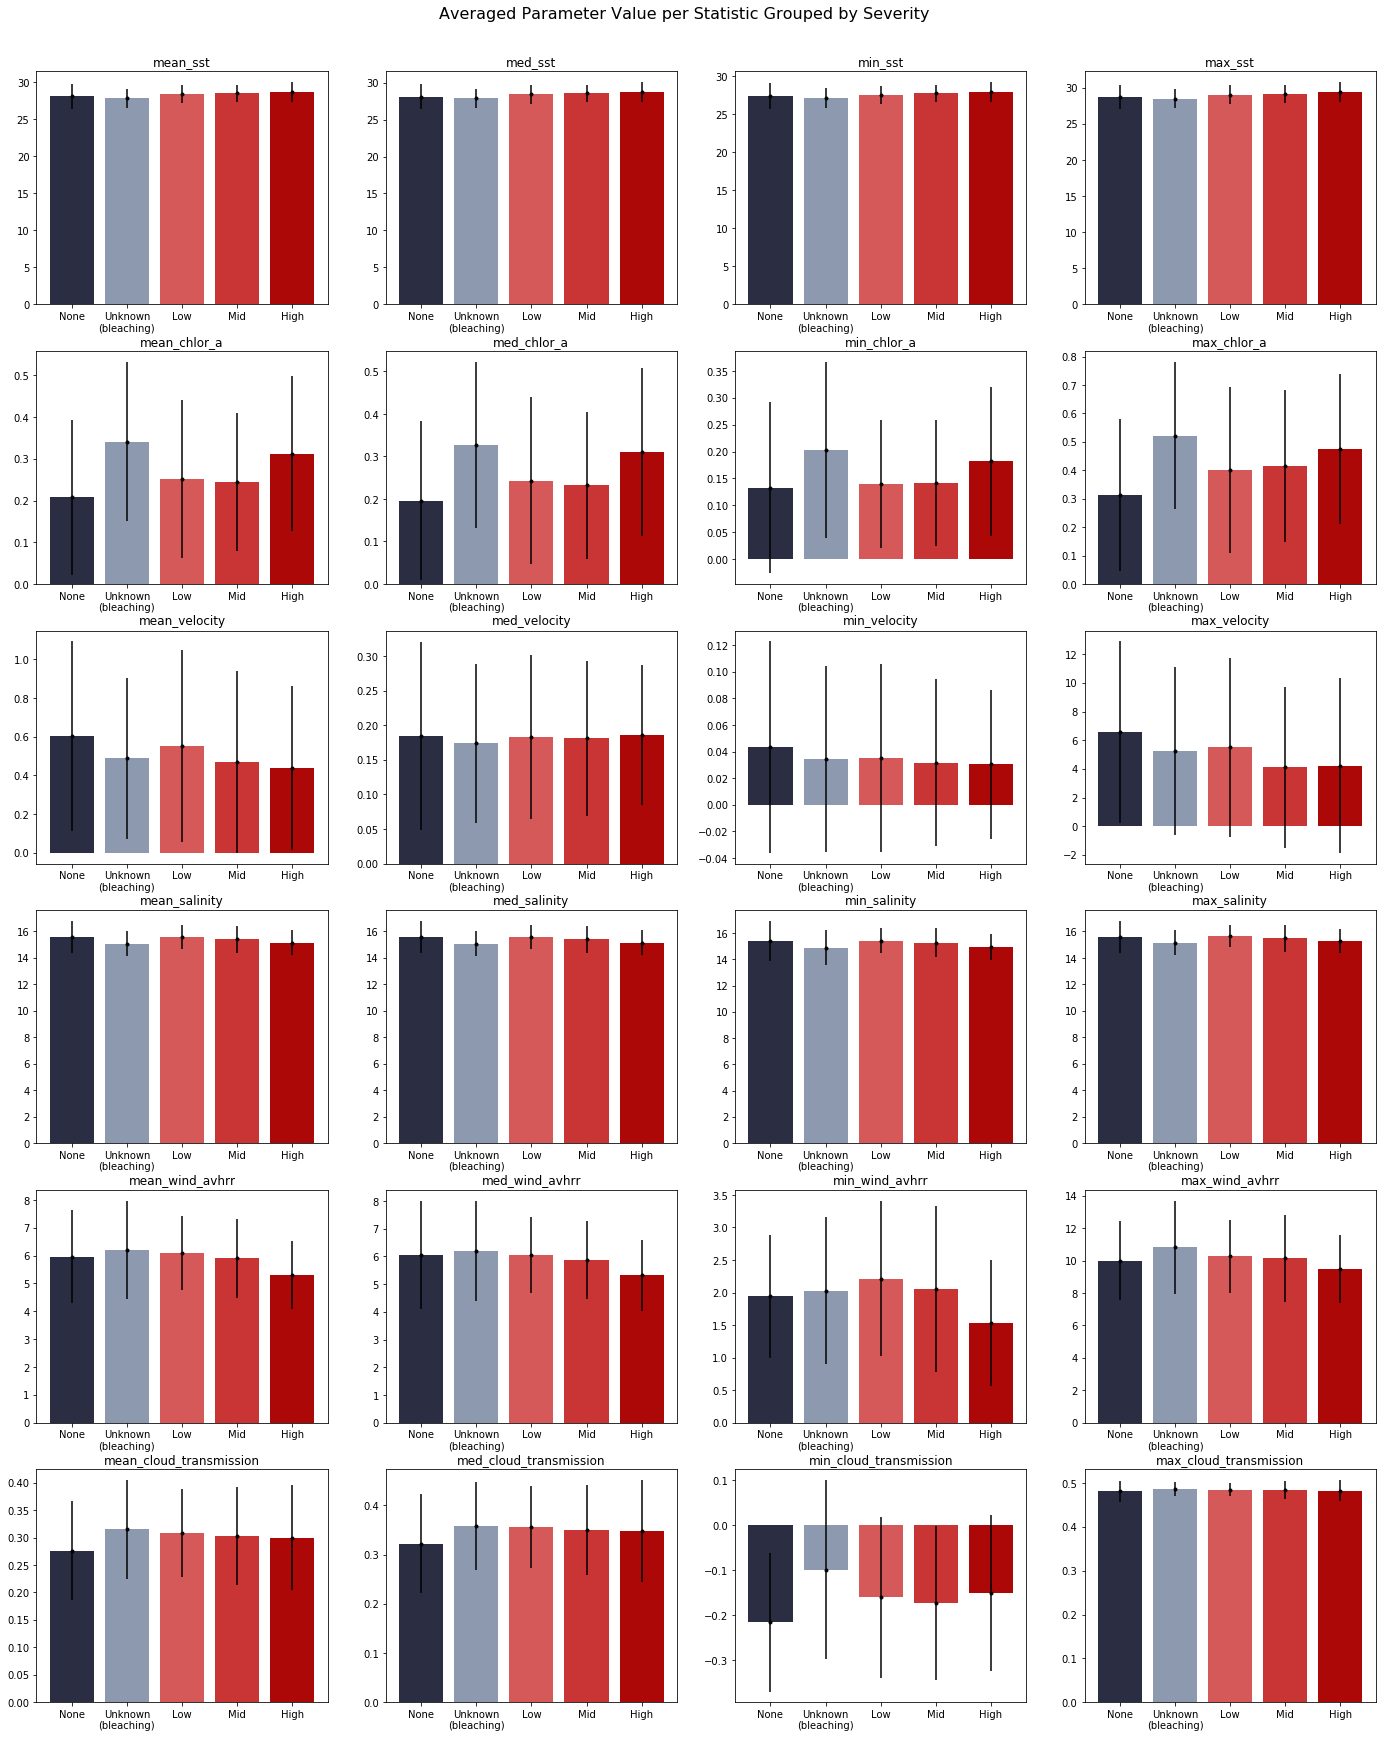

In [205]:
colors =['#2B2D42', '#8D99AE', '#D65959', '#C93434', '#AC0808']
ordered_severity = [0, -1, 1, 2, 3]
counter = 1
plt.figure(figsize=(24, 30))
for variable in variables:
    for stat in stats:
        plt.subplot(len(variables), len(stats), counter)
        for severity in ordered_severity:
            values =  db[db['severity'] == severity]
            mean_val = values[stat + variable].mean()
            var_val = math.sqrt(values[stat + variable].var())
            plt.errorbar(severity, mean_val, var_val, fmt='.', color='black')
            plt.bar(severity, mean_val, color=colors[severity+1])
            plt.xticks([-1, 0, 1, 2, 3], ['None', 'Unknown\n(bleaching)', 'Low', 'Mid', 'High'])
            #plt.legend(['Healthy', 'Bleaching'])
            title = str(stat + variable)
            plt.title(title)
        counter += 1
plt.suptitle("Averaged Parameter Value per Statistic Grouped by Severity", size=16, y=0.91)
#plt.savefig('figures/Mean Value by Severity - Window 10.png', dpi=300, bbox_inches='tight')
plt.show()

### A box plot representation of the median values for each of the parameters grouped by bleaching severity

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


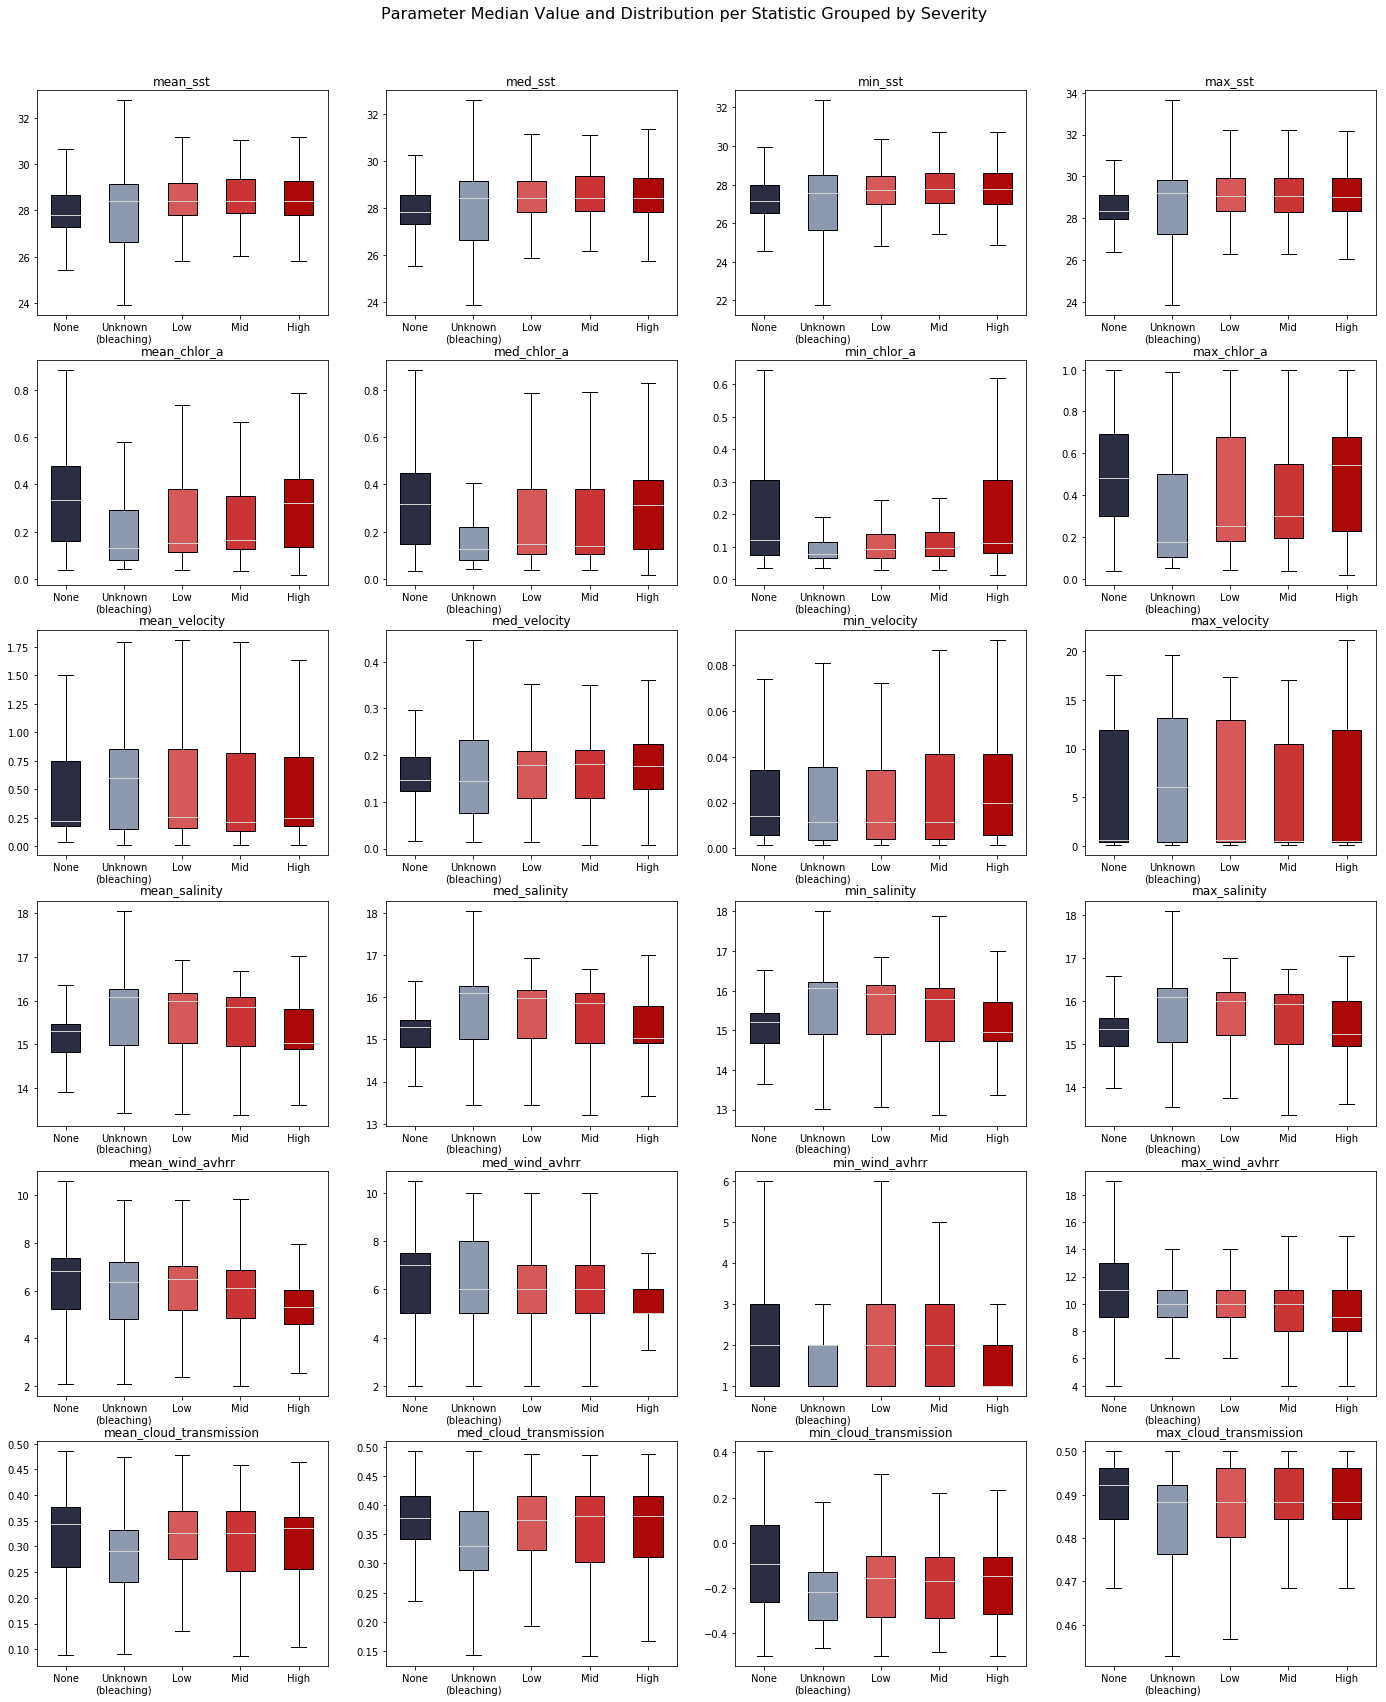

In [206]:
ordered_severity = [0, -1, 1, 2, 3]
counter = 1
plt.figure(figsize=(24, 29))
for variable in variables:
    for stat in stats:
        plt.subplot(len(variables), len(stats), counter)
        data = []
        for severity in ordered_severity:
            values = db[db['severity'] == severity]
            data.append(values[stat + variable].dropna())

        box_plot = plt.boxplot(data, positions=[0, 1, 2, 3, 4],
        showfliers=False,
        patch_artist=True,
        medianprops={"color": '#d1d1d1'})

        title = str(stat + variable)
        plt.title(title)
        plt.xticks([0, 1, 2, 3, 4], ['None', 'Unknown\n(bleaching)', 'Low', 'Mid', 'High'])
        counter += 1
        for bplot in box_plot:
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)
plt.suptitle("Parameter Median Value and Distribution per Statistic Grouped by Severity", size=16, y=0.92)
#plt.savefig('figures/Box and Whisker Grouped by Severity - Window 10.png', dpi=300, bbox_inches='tight')
plt.show()

Compute a tSNE dimensionality reduction for a broad set of inputs

I'm curious whether these parameters are able to detect/determine whether a bleaching event is occuring. If the parameters did carry a signature of bleaching, I would imagine that we would see clustering for bleaching and non-bleaching events.

Note: I think this is not coded well. Very clunky

In [215]:

mean_values = []
min_values = []
max_values = []
var_values = []
for variable in variables:
    mean_values.append(db['mean_' + variable])
    max_values.append(db['max_' + variable])
    min_values.append(db['min_' + variable])
    var_values.append(db['variance_' + variable])
mean_values = np.array(mean_values)
min_values = np.array(min_values)
max_values = np.array(max_values)
var_values = np.array(var_values)

values = np.concatenate([mean_values, min_values, max_values, var_values])
filtered_values = []
severities = []
for row in range(values.shape[1]):
    if sum(np.isnan(values[:,row])) == 0:
        filtered_values.append(values[:,row])
        severities.append(db['severity'][row])

filtered_values = np.array(filtered_values)
severities = np.array(severities)
#filtered_values[np.isnan(filtered_values)] = 0

x_tsne = TSNE(learning_rate=100).fit_transform(filtered_values)
x_tsne = np.array(x_tsne)

Plot a tSNE reduction for the dataset.

It seems that some bleaching/non-bleaching events do cluster, however, the deliniation is not too strong.

Additionally, the cirucluar ring-like clusters indicate to me that there are many sets of events that are nearly identical to one another.

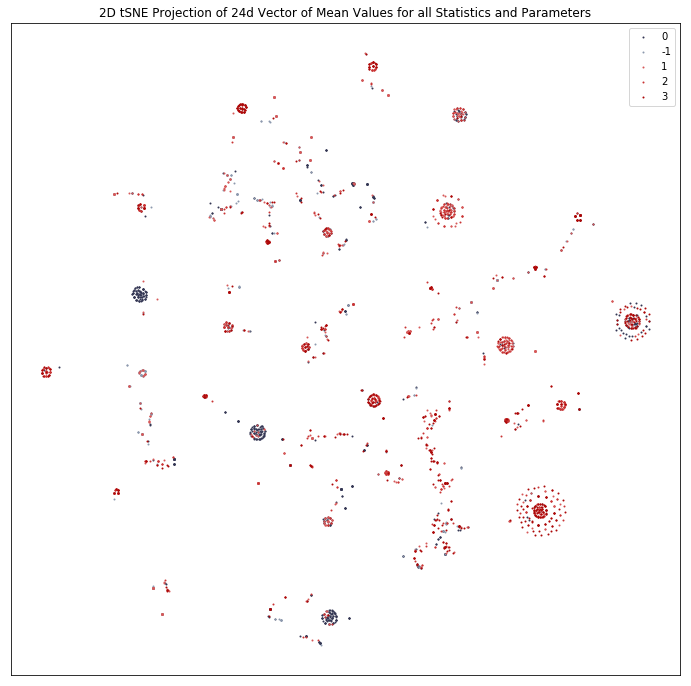

In [216]:
counter = 0
plt.figure(figsize=(12, 12))
for severity in ordered_severity:
    index = severities == severity
    plt.scatter(x_tsne[index,0], x_tsne[index,1], s=1, color=colors[counter])
    counter += 1
plt.legend(ordered_severity)
plt.xticks([])
plt.yticks([])
plt.title('2D tSNE Projection of 24d Vector of Mean Values for all Statistics and Parameters')
#plt.savefig('figures/tSNE Mean, Min, Max, Var - Window 10 - Params 6 - No NaNs.png', dpi=300, bbox_inches='tight')
plt.show()

### Plots that I don't like

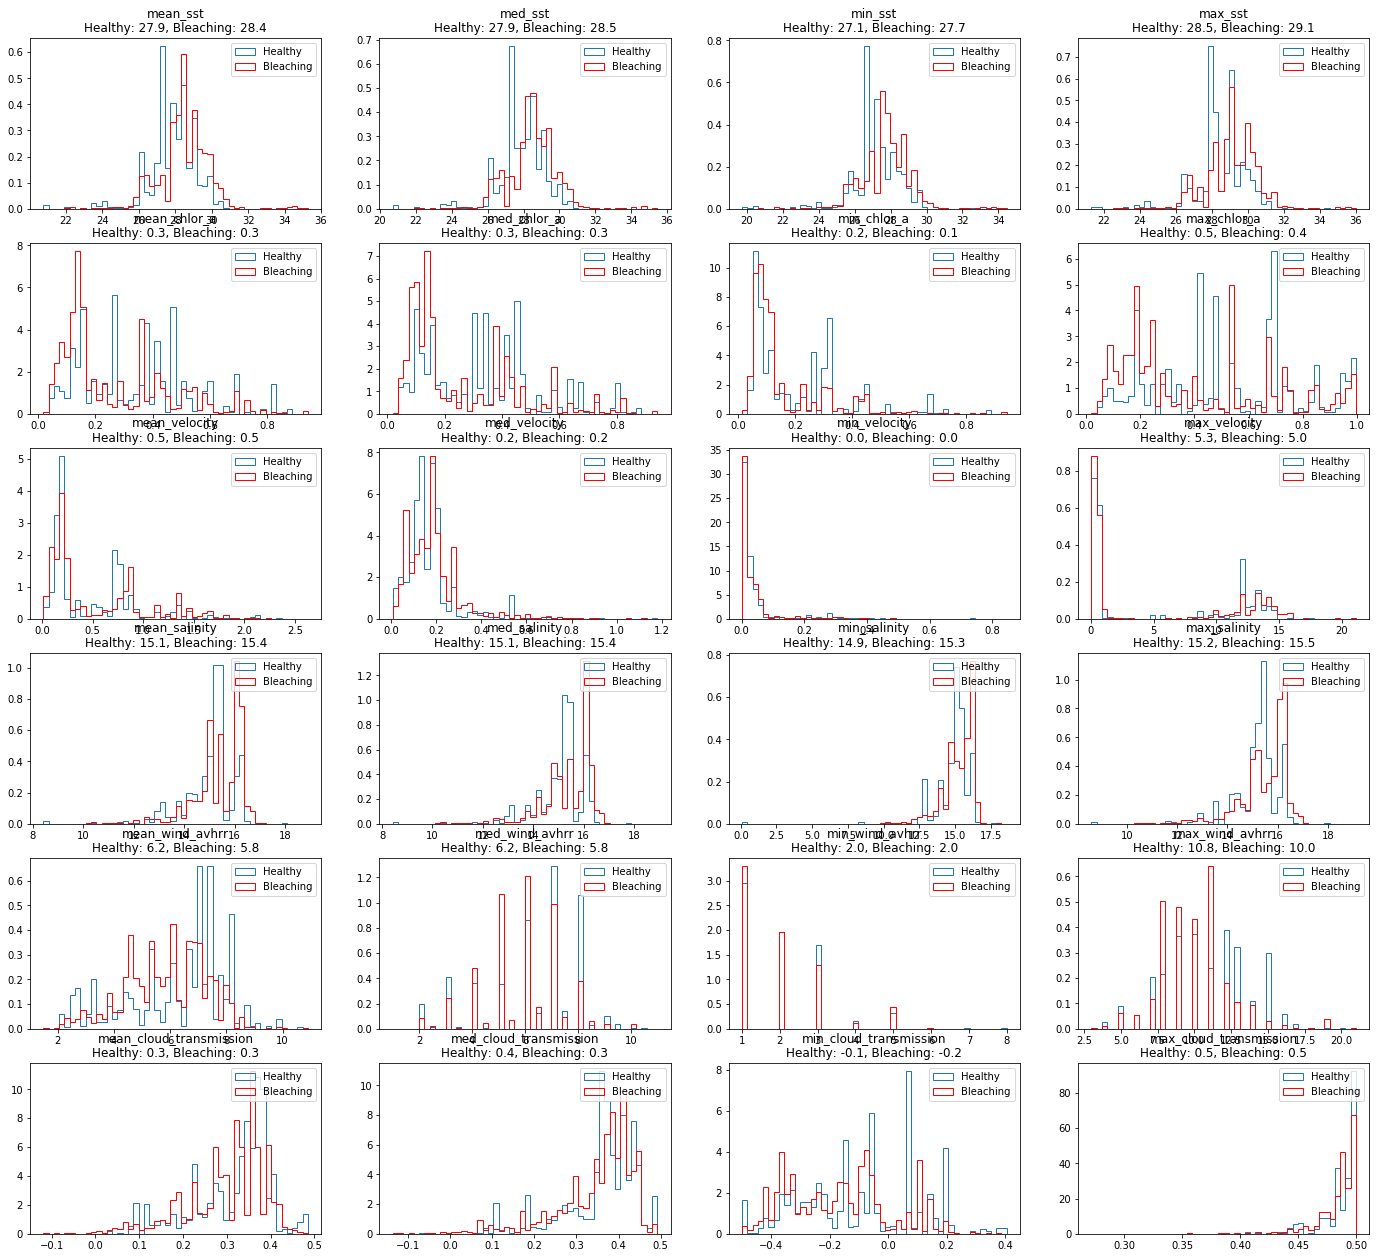

In [219]:
counter = 1
plt.figure(figsize=(24, 22))
for variable in variables:
    for stat in stats:
        val_healthy = healthy[stat + variable].dropna()
        val_bleaching = bleaching[stat + variable].dropna()
        plt.subplot(len(variables), len(stats),counter)
        bins = np.histogram(np.hstack((val_healthy, val_bleaching)), bins=50)[1]
        plt.hist(val_healthy, bins, histtype='step', density=True)
        plt.hist(val_bleaching, bins, color='r', histtype='step', density=True)
        plt.legend(['Healthy', 'Bleaching'])
        title = str(stat + variable + "\nHealthy: {0:.1f}, Bleaching: {1:.1f}").format(np.mean(val_healthy), np.mean(val_bleaching))
        plt.title(title)
        counter += 1
#plt.savefig('Distribution of Mean Values.png', dpi=600)
plt.show()

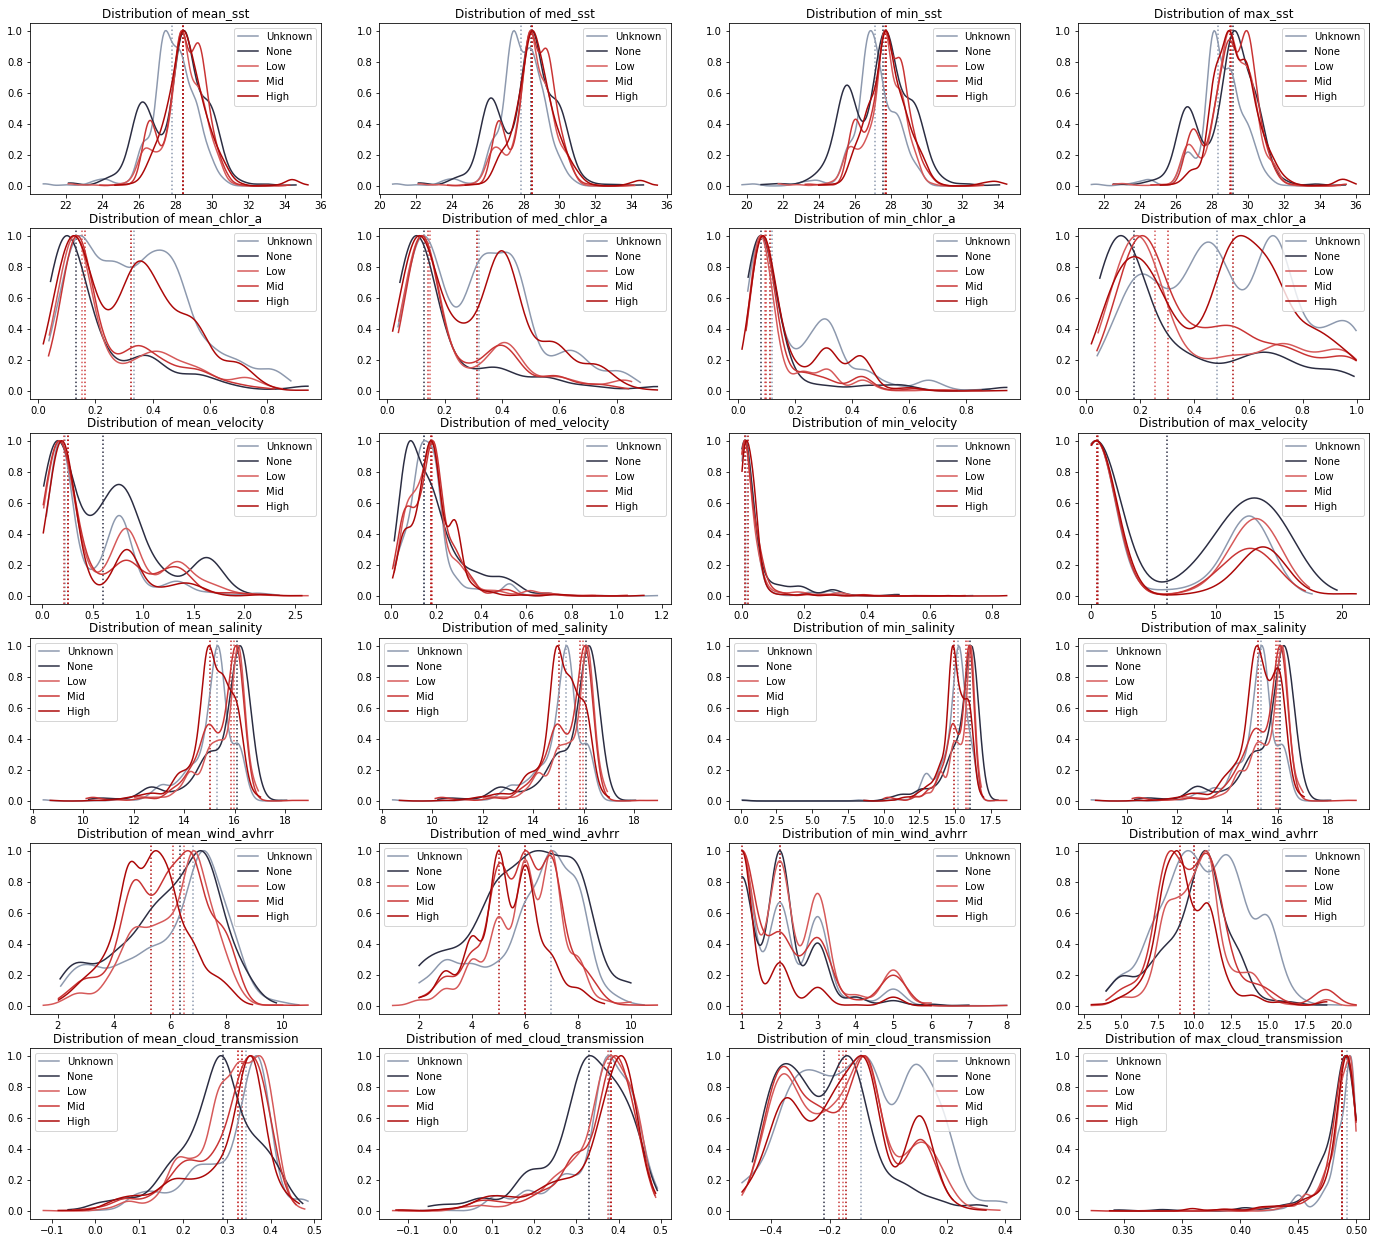

In [220]:
counter = 1
plt.figure(figsize=(24, 22))
for variable in variables:
    for stat in stats:
        plt.subplot(len(variables), len(stats),counter)
        for severity in ordered_severity:
            values =  db[db['severity'] == severity]
            val = values[stat + variable].dropna()
            #print("Severity", severity, "Stat", stat + variable, len(val))
            min_val = np.min(val)
            max_val = np.max(val)
            xs = np.linspace(min_val, max_val, 200)

            density = gaussian_kde(val)
            median = np.median(val)

            plt.plot(xs, density(xs)/np.max(density(xs)), color=colors[severity+1])
            plt.vlines(median, -0.05, 1.05, linestyle=':', color=colors[severity+1])
            plt.ylim([-0.05,1.05])
            plt.legend(['Unknown', 'None', 'Low', 'Mid', 'High'])
            title = str("Distribution of " + stat + variable)
            plt.title(title)
        counter += 1
#plt.savefig('Mean Value Comparison.png', dpi=600)
plt.show()